## ISM機能階層分析

#### ライブラリのインポート

In [197]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

#### 機能項目相互間の関係のマトリックス宣言

In [198]:
start_column = 7    # マトリックスの開始列（G列）
start_row = 5       # マトリックスの開始行（5行）
num = 19            # 読み取るセルの範囲（num 行の正方形を読み取る）

In [199]:
# 階層構造を定義した2次元マトリックスを取得する関数
def read_data(start_row, start_column, num):
    df = pd.read_excel("機能項目相互間の関係.xlsx", header=None, sheet_name="機能項目相互間の関係", 
                       skiprows=start_row - 1, usecols=range(start_column - 1, start_column - 1 + num))
    
    data = np.where(df.values == "○", 1, 0)

    return data

# データを読み取る
matrix = read_data(start_row, start_column, num)
matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1],
       [0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0,

#### 各種関数の定義

In [208]:
# ISM機能階層分析を行う関数
def ism_FHA(matrix):

    ###----------可達行列作成処理----------###
    # 行列のサイズを取得
    n = len(matrix)

    print('\n----------隣接行列----------')
    matrix = matrix.astype(bool)
    I = np.eye(n).astype(bool)
    adj_matrix = np.logical_or(matrix, I)
    print(adj_matrix.astype(int))

    print('\n----------可達行列----------')
    reachability_matrix = adj_matrix.copy()
    while not np.array_equal(reachability_matrix, reachability_matrix @ adj_matrix):
        reachability_matrix = reachability_matrix @ adj_matrix  #@演算子を利用することで行列積を求める（bool演算）
    print(reachability_matrix.astype(int))

    ###-------エッジ作成順序判断処理-------###
    # aに行番号を順番に格納する
    a = list(range(n))

    # 最後に残る配列
    final_list = reachability_matrix.copy()

    # 繰り返し回数と削除した行を関連付ける辞書配列を初期化
    iterations = 0
    removed_rows_dict = {}

    while len(final_list) > 2:
        single_true_rows = find_single_true_row(final_list) # 1つだけTrueが含まれている行を記録
        
        # 繰り返し回数と削除した行を記録
        iterations += 1
        removed_rows_dict[iterations] = [a[row] for row in single_true_rows]
        a = np.delete(a, single_true_rows)  #記録した行の要素は削除

        # 記録した行とそれに対応する列を削除
        final_list = remove_rows_and_columns(final_list, single_true_rows)

    # 残った配列aから，Trueが多い方の行の階層を上にする
    true_counts = np.sum(final_list, axis=1)    # 行ごとにTrueの数を数える
    max_row_index = np.argmax(true_counts)      # 最大値を持つ行番号を取得
    min_row_index = np.argmin(true_counts)      # 最小値を持つ行番号を取得

    removed_rows_dict[iterations + 1] = [a[min_row_index]]
    removed_rows_dict[iterations + 2] = [a[max_row_index]]

    print("\n--------残った2×2行列--------")
    print(final_list.astype(int))
    print("\n--------エッジ作成順序--------")
    print(removed_rows_dict)

    return removed_rows_dict

# 指定した行と列を削除する関数
def remove_rows_and_columns(matrix, rows_to_remove):
    matrix = np.delete(matrix, rows_to_remove, axis=0)
    matrix = np.delete(matrix, rows_to_remove, axis=1)
    return matrix

# Trueが1つだけ含まれている行を探す関数
def find_single_true_row(matrix):
    single_true_rows = []
    for i in range(len(matrix)):
        if np.sum(matrix[i]) == 1:
            single_true_rows.append(i)
    return single_true_rows

In [209]:
# ノードの配置を取得する関数
def get_layer_positions(removed_rows_dict, custom_pos={}):
    positions = {}
    current_x = 0
    for layer, nodes in removed_rows_dict.items():
        for node in nodes:
            positions[node] = (current_x, -layer)
            current_x += 1
        current_x = 0

    # custom_posで指定したノード番号のx座標を辞書リストに追加する
    for node, x_coord in custom_pos.items():
        positions[node] = (x_coord, positions[node][1])

    return positions

# グラフオブジェクトを作成する関数
def create_graph(removed_rows_dict):
    G = nx.DiGraph()

    # ノードをグラフに追加
    for i in range(matrix.shape[0]):
        G.add_node(i)

    # matrixを参照しエッジを追加する関数
    def add_edges(source_node, target_nodes, target_layer_dict):
        sorted_target_nodes = sorted(target_nodes, key=lambda node: target_layer_dict[node], reverse=True)
        for target_node in sorted_target_nodes:
            if source_node != target_node and not nx.has_path(G, source_node, target_node) and not nx.has_path(G, target_node, source_node):
                G.add_edge(source_node, target_node)
                print('Edge added:', source_node, '->' , target_node)

    sorted_removed_rows_dict = dict(sorted(removed_rows_dict.items()))  # 階層を昇順にソート

    # target_nodeが属する階層の情報を辞書リストとして取得
    target_layer_dict = {}
    for layer, nodes in removed_rows_dict.items():
        for node in nodes:
            target_layer_dict[node] = layer
    
    print('\n--------エッジ追加処理--------')
    for layer, nodes in sorted_removed_rows_dict.items():
        target_nodes = []
        for node in nodes:
            target_nodes = matrix[node].nonzero()[0]
            add_edges(node, target_nodes, target_layer_dict)
    
    return G

#### ISM機能階層分析 と 階層グラフの作成


----------隣接行列----------
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1]
 [1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1]
 [1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1]
 [1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1]
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1]
 [0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

----------可達行列----------
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1]
 [1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1]
 [1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1]
 [1 

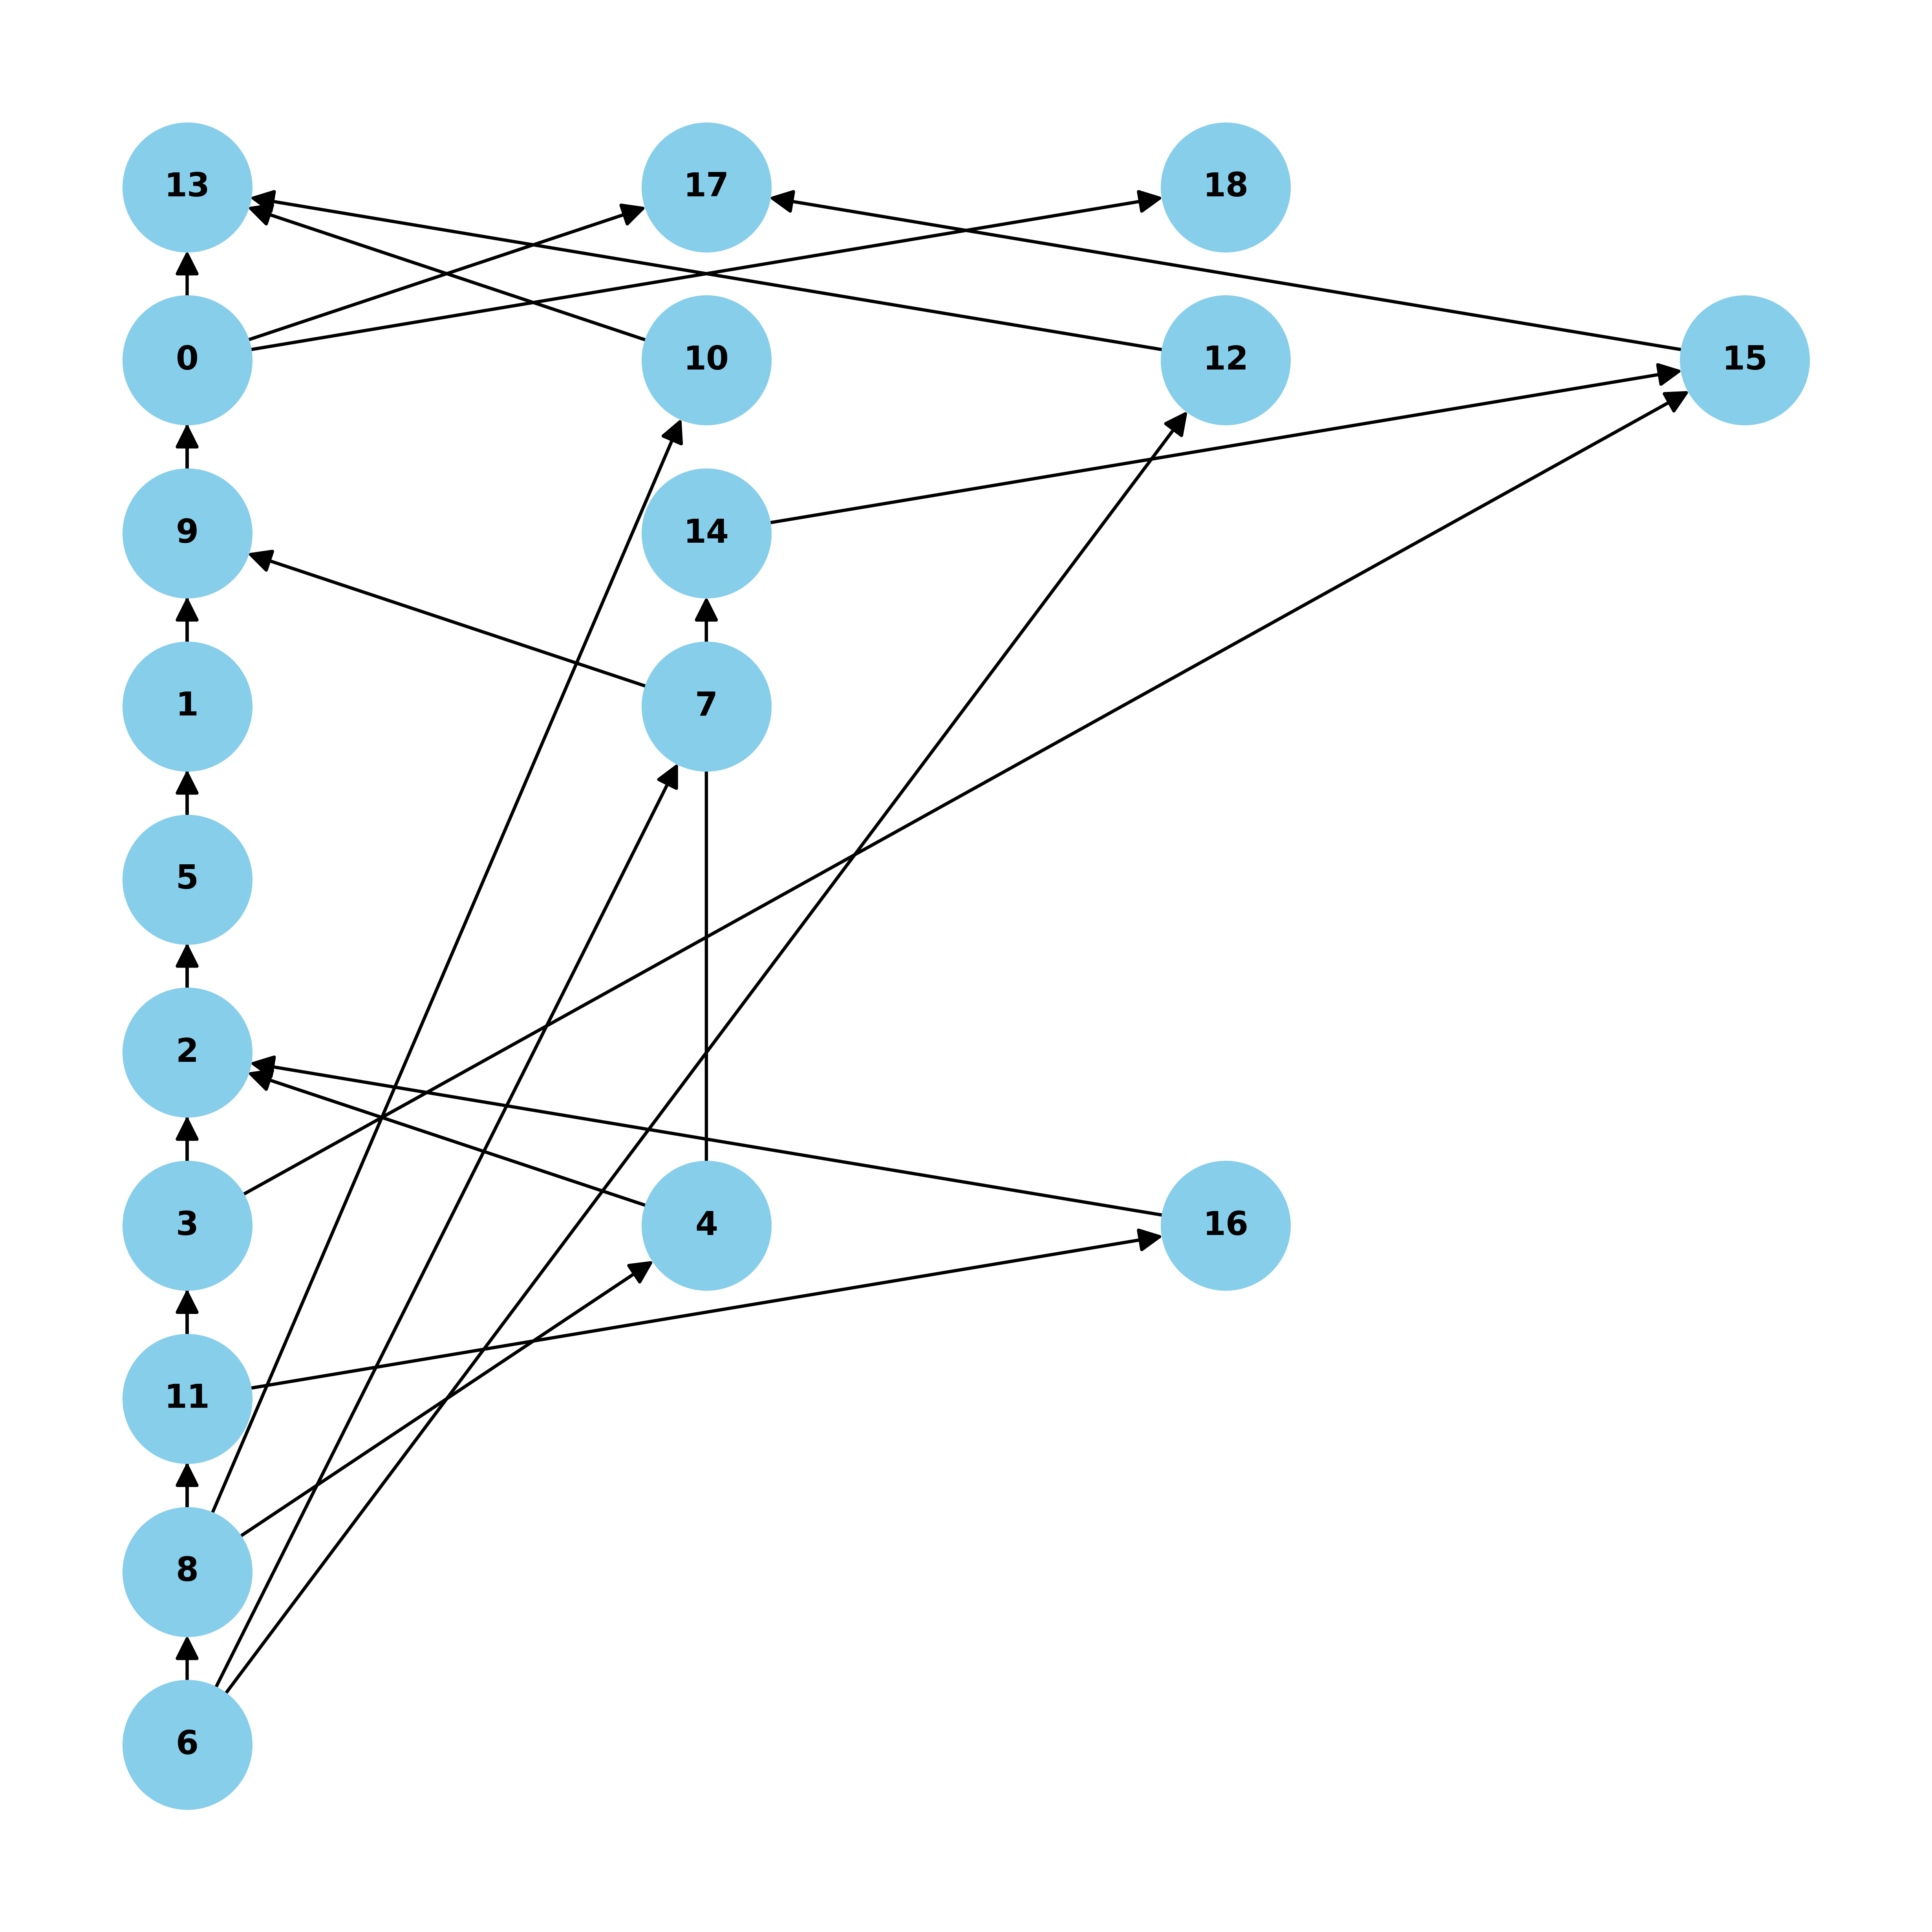

In [210]:
# ISM機能階層分析を実行
removed_rows_dict = ism_FHA(matrix)

# グラフを作成
G = create_graph(removed_rows_dict)

# ノードの配置を取得
pos = get_layer_positions(removed_rows_dict)

# グラフを描画して表示
plt.figure(figsize=(8, 8), dpi=600)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=15)
plt.savefig('fig\ISM-FHA_exercise.png', format='png')
plt.show()

ノードの位置を調節  
- エッジが重なって表示されているところがあるため  
- 見やすくなるようにするため  

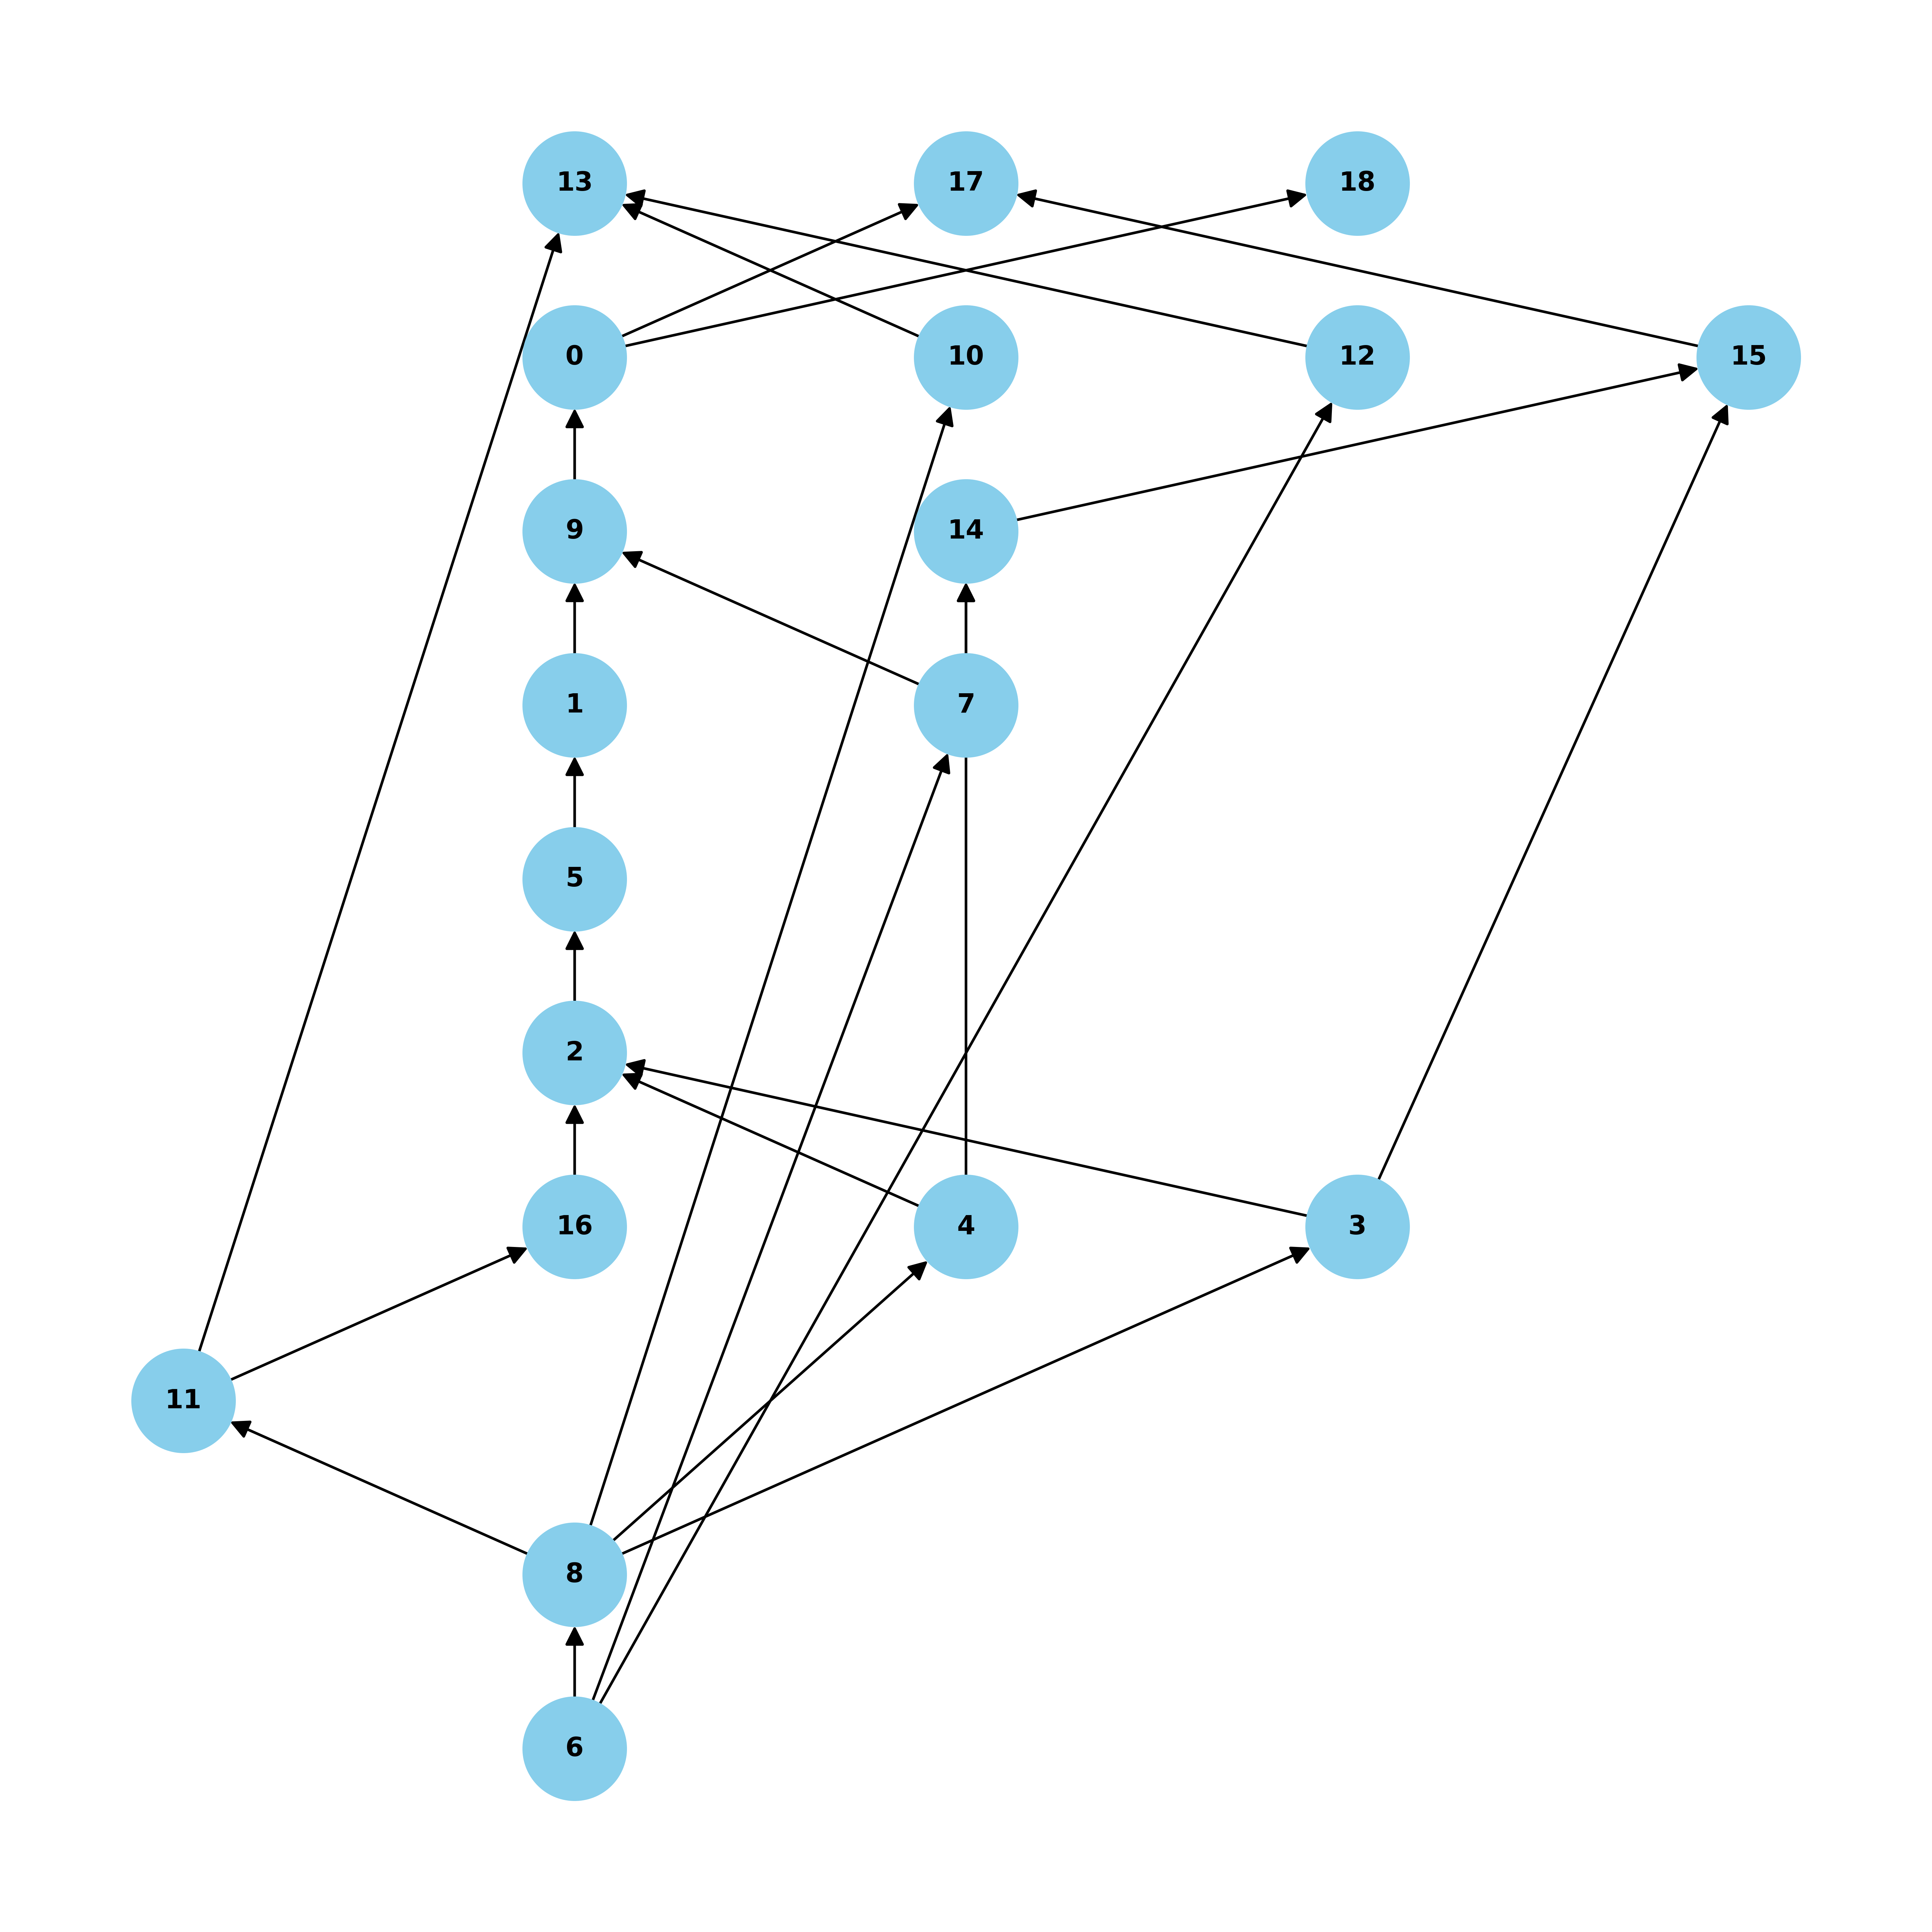

In [211]:
# custom_posでノード番号に対応するx座標を指定する
custom_pos = {3 : 2, 
              4 : 1,
              11: -1,
              16: 0}

# ノードの配置を取得
pos_fix = get_layer_positions(removed_rows_dict, custom_pos)

# グラフを描画して表示
plt.figure(figsize=(10, 10), dpi=600)
nx.draw(G, pos_fix, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=15)
plt.savefig('fig\ISM-FHA_exercise_fix.png', format='png')
plt.show()